In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loan_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/loan.csv')
payment_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/payment.csv')
clarity_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/clarity_underwriting_variables.csv')

<ipython-input-232-3c75fa8027dc>:3: DtypeWarning:

Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

In [ ]:
payment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loanId             689364 non-null  object 
 1   installmentIndex   689364 non-null  int64  
 2   isCollection       689364 non-null  bool   
 3   paymentDate        689364 non-null  object 
 4   principal          689364 non-null  float64
 5   fees               689364 non-null  float64
 6   paymentAmount      689364 non-null  float64
 7   paymentStatus      525307 non-null  object 
 8   paymentReturnCode  31533 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 42.7+ MB


In [ ]:
clarity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

In [ ]:
loan_df1 = loan_df.loc[(loan_df['isFunded'] == 1)]
# Filter out loans that have been funded (isFunded = 1). Only consider loans that have been funded because only these loans have actually entered the repayment stage.
# Suitable for predicting repayment behavior and risk.

## Data cleaning

In [ ]:
payment_df1 = payment_df.pivot_table(index='loanId',values='installmentIndex',columns='paymentStatus',aggfunc='count',fill_value=0).rename_axis(None, axis=1).reset_index()

In [ ]:
combine_df = (loan_df1.merge(payment_df1, on='loanId', how='left'))
combine_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,clarityFraudId,hasCF,Cancelled,Checked,Complete,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,...,569eb3a3e4b096699f685d64,1,3.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28T19:54:22.982000,True,2016-11-29T20:30:40.640000,2.0,True,1,...,NaN,0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0
2,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,2017-03-01T16:15:13.016000,0.0,True,1,...,58b6eef8e4b0b6fca82fd426,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,True,2017-01-31T18:00:14.520000,2.0,True,1,...,58450a15e4b0bb9d6d7344c7,1,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,True,2016-08-29T15:05:04.014000,0.0,True,1,...,578f9346e4b0810ad5e7b72e,1,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
clarity_df1=clarity_df[['clearfraudscore','underwritingid']]
combine_df = combine_df.merge(clarity_df1,left_on='clarityFraudId',right_on='underwritingid',how='left')
combine_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,Cancelled,Checked,Complete,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped,clearfraudscore,underwritingid
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,...,3.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,879.0,569eb3a3e4b096699f685d64
1,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28T19:54:22.982000,True,2016-11-29T20:30:40.640000,2.0,True,1,...,0.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
2,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,2017-03-01T16:15:13.016000,0.0,True,1,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,658.0,58b6eef8e4b0b6fca82fd426
3,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,True,2017-01-31T18:00:14.520000,2.0,True,1,...,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,835.0,58450a15e4b0bb9d6d7344c7
4,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,True,2016-08-29T15:05:04.014000,0.0,True,1,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,624.0,578f9346e4b0810ad5e7b72e


In [ ]:
print(combine_df.isnull().sum().sort_values(ascending=False))

clearfraudscore                     6894
underwritingid                      6802
clarityFraudId                      6622
Skipped                             1796
Returned                            1796
Rejected Awaiting Retry             1796
Rejected                            1796
Pending                             1796
Complete                            1796
Checked                             1796
Cancelled                           1796
nPaidOff                              21
fpStatus                               9
leadCost                               0
hasCF                                  0
loanId                                 0
anon_ssn                               0
state                                  0
originallyScheduledPaymentAmount       0
loanAmount                             0
loanStatus                             0
isFunded                               0
approved                               0
originatedDate                         0
originated      

In [ ]:
missing_percentage_df = combine_df.isnull().sum() * 100/len(combine_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_percentage_df)

loanId                               0.000000
anon_ssn                             0.000000
payFrequency                         0.000000
apr                                  0.000000
applicationDate                      0.000000
originated                           0.000000
originatedDate                       0.000000
nPaidOff                             0.053871
approved                             0.000000
isFunded                             0.000000
loanStatus                           0.000000
loanAmount                           0.000000
originallyScheduledPaymentAmount     0.000000
state                                0.000000
leadType                             0.000000
leadCost                             0.000000
fpStatus                             0.023088
clarityFraudId                      16.987327
hasCF                                0.000000
Cancelled                            4.607255
Checked                              4.607255
Complete                          

In [ ]:
cols = ["Skipped", "Rejected Awaiting Retry",'Rejected','Pending','Complete','Checked','Returned','Cancelled']
combine_df[cols]=combine_df[cols].fillna(0)
combine_df = combine_df.dropna()
print(combine_df.isnull().sum().sort_values(ascending=False))

loanId                              0
leadCost                            0
clearfraudscore                     0
Skipped                             0
Returned                            0
Rejected Awaiting Retry             0
Rejected                            0
Pending                             0
Complete                            0
Checked                             0
Cancelled                           0
hasCF                               0
clarityFraudId                      0
fpStatus                            0
leadType                            0
anon_ssn                            0
state                               0
originallyScheduledPaymentAmount    0
loanAmount                          0
loanStatus                          0
isFunded                            0
approved                            0
nPaidOff                            0
originatedDate                      0
originated                          0
applicationDate                     0
apr         

In [ ]:
unique_statuses = combine_df['loanStatus'].unique()
print(unique_statuses)

['Paid Off Loan' 'New Loan' 'Internal Collection' 'External Collection'
 'Returned Item' 'Pending Paid Off' 'Charged Off Paid Off'
 'Settled Bankruptcy' 'Settlement Paid Off' 'Charged Off'
 'Settlement Pending Paid Off']


Paid Off Loan: A loan that has been fully repaid.

New Loan: A newly issued loan.

Internal Collection: After a loan defaults, internal collection attempts to recover the loan.

External Collection: After a loan defaults, an external agency intervenes to recover the loan.

Returned Item: A single repayment failure caused by insufficient funds.

Pending Paid Off: A loan is in a state of being fully repaid.

Charged Off Paid Off: A loan that was originally written off is finally repaid.

Settled Bankruptcy: A loan that is resolved through legal procedures due to the applicant's bankruptcy.

Settlement Paid Off: A loan that is fully repaid through settlement.

Charged Off: A loan is deemed unrecoverable by a bank or lending institution and is included in bad debts.

Settlement Pending Paid Off: A loan is being repaid through settlement.

Loans are classified by risk level based on their status, from low risk to very high risk.

**Low Risk**:
* Paid Off Loan,
* Pending Paid Off

**Medium Risk**: Some risk is involved, but the borrower has the ability or intention to settle the debt

* New Loan: A newly issued loan. The risk level depends on the borrower's credit history and loan conditions, and is generally considered medium risk.

* Returned Item: A single repayment failure due to insufficient funds. This may be a temporary cash flow problem and needs to be monitored for recurrence.

* Charged Off Paid Off: A loan that was originally written off was eventually repaid. Indicates that the borrower has repaid the debt despite a serious default history.

* Settlement Paid Off: A loan that was fully repaid through settlement. Although the borrower failed to repay as originally planned, the debt was eventually settled through settlement.

* Settlement Pending Paid Off: The loan is being repaid through settlement. The borrower is working to settle the debt, but it has not yet been completed.

**High Risk**: Clear signs of default, which may result in loan losses

* Internal Collection: After the loan defaults, internal collection attempts to recover the loan. Indicates that the borrower has defaulted and the lender is trying to recover the outstanding debt.

* External Collection: After the loan defaults, an external agency intervenes to recover the loan. Usually indicates that internal collection attempts have failed and the risk has increased further.

**Very High Risk**: Involves legal proceedings, usually foreshadowing major financial problems or loan losses

* Settled Bankruptcy: A loan that is resolved through legal proceedings due to the applicant's bankruptcy. Usually means that the borrower's financial situation is bad and the possibility of loan loss is high.

* Charged Off: The loan is deemed uncollectible by the bank or lender and is recorded as a bad debt. This is the highest risk status, and loan losses are a foregone conclusion.



In [ ]:
# Low risk is 0, medium risk is 1, high risk is 2, and very high risk is 3
risk_map = {'Paid Off Loan': 0,
    'Pending Paid Off': 0,
    'New Loan': 1,
    'Returned Item': 1,
    'Charged Off Paid Off': 1,
    'Settlement Paid Off': 1,
    'Settlement Pending Paid Off': 1,
    'Internal Collection': 2,
    'External Collection': 2,
    'Settled Bankruptcy': 3,
    'Charged Off': 3}
combine_df['Risk_Level'] = combine_df['loanStatus'].map(risk_map)
combine_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,Checked,Complete,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped,clearfraudscore,underwritingid,Risk_Level
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,879.0,569eb3a3e4b096699f685d64,0
2,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,2017-03-01T16:15:13.016000,0.0,True,1,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,658.0,58b6eef8e4b0b6fca82fd426,1
3,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,True,2017-01-31T18:00:14.520000,2.0,True,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,835.0,58450a15e4b0bb9d6d7344c7,0
4,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,True,2016-08-29T15:05:04.014000,0.0,True,1,...,13.0,0.0,0.0,0.0,0.0,0.0,0.0,624.0,578f9346e4b0810ad5e7b72e,0
5,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25T03:05:18.849000,True,2016-05-25T15:11:36.260000,3.0,True,1,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,770.0,56621584e4b0100e84141586,0


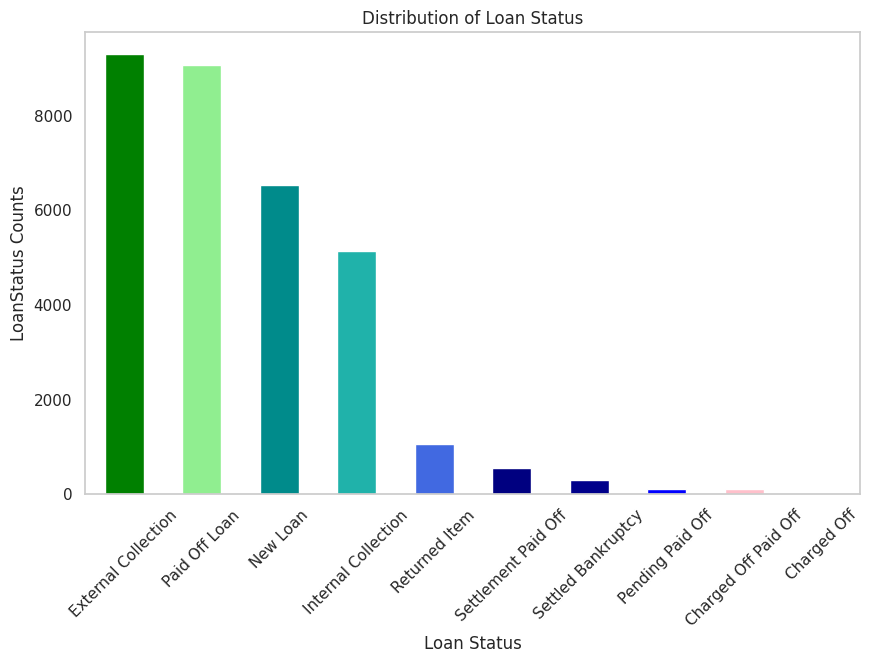

In [ ]:
colors = ['green', 'lightgreen', 'darkcyan', 'lightseagreen', 'royalblue', 'navy', 'darkblue', 'blue', 'pink', 'magenta']
plt.figure(figsize=(10, 6))
loanStatus_counts = combine_df['loanStatus'].value_counts()
loanStatus_counts.plot(kind='bar', color=colors[:len(risk_level_counts)])
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('LoanStatus Counts')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

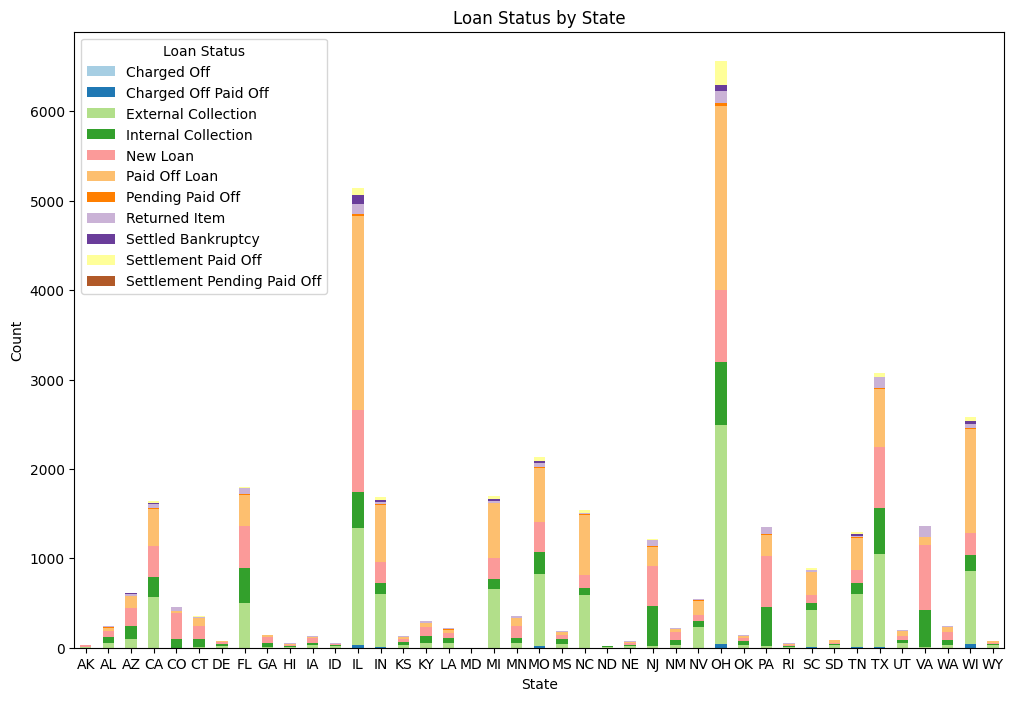

In [ ]:
ct = pd.crosstab(loan_df1['state'], loan_df1['loanStatus'])

ct.plot(kind='bar', stacked=True, colormap='Paired',figsize=(12, 8))
plt.title('Loan Status by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='State status of loans issued')
plt.xticks(rotation=0)
plt.legend(title='Loan Status', loc='upper left')
plt.show()

# Ohio has the highest default rate, while Illinois and Ohio have the highest default rates in the "new loans" and "repaid loans" categories compared to other states.
# This is also closely related to the local economic scale and population size, which also means there is a greater market demand.
# Financial institutions can assess the risks and benefits of different regions and formulate corresponding strategies

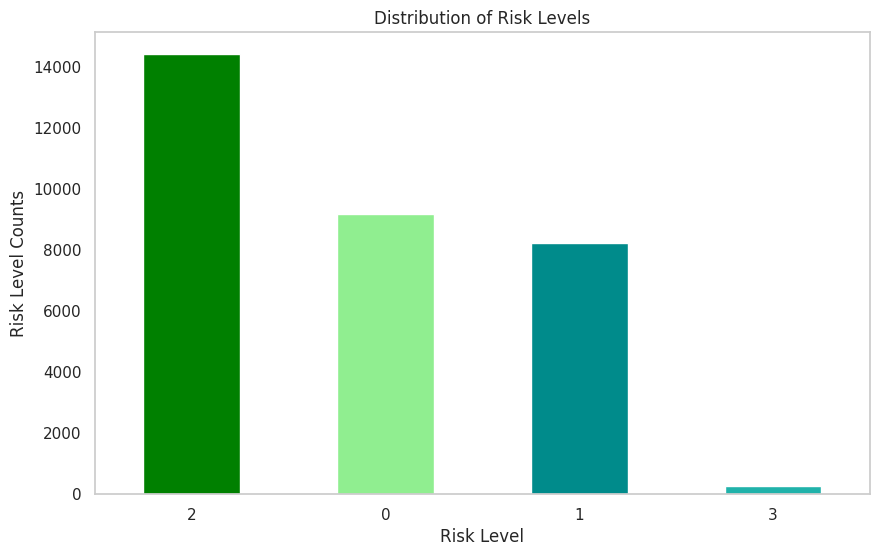

In [ ]:
plt.figure(figsize=(10, 6))
risk_level_counts = combine_df['Risk_Level'].value_counts()
risk_level_counts.plot(kind='bar', color=colors[:len(risk_level_counts)])
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Risk Level Counts')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

<ipython-input-160-529f1e92069a>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='Risk_Level', ylabel='loanAmount'>

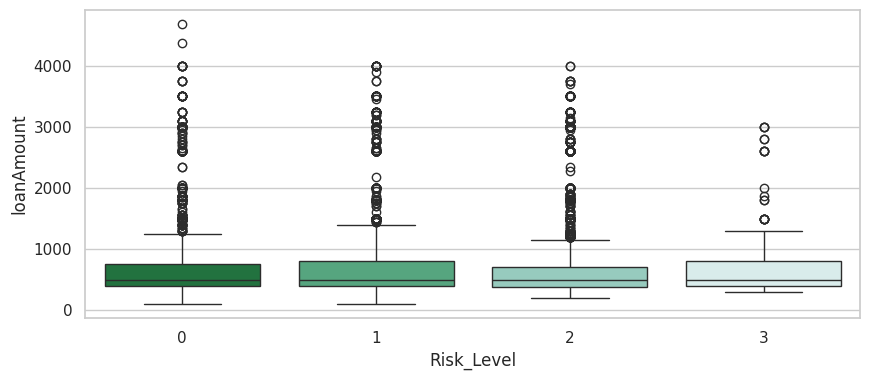

In [ ]:
# Visualize loan amounts at different risks
sns.set(style="whitegrid")

plt.figure(figsize=(10, 4))
sns.boxplot(x=combine_df['Risk_Level'],
            y=combine_df['loanAmount'],
            palette=("BuGn_r"),
           data = loan_df1)
# The amount of loans for very high risk is less than other risk levels.

In [ ]:
unique_statuses1 = loan_df1['state'].unique()
print(unique_statuses1)

['CA' 'MO' 'NJ' 'WI' 'IL' 'MI' 'FL' 'SC' 'OH' 'NV' 'IN' 'VA' 'TN' 'OK'
 'NC' 'TX' 'PA' 'HI' 'MS' 'KY' 'AL' 'GA' 'NM' 'ID' 'ND' 'AZ' 'CO' 'NE'
 'SD' 'MN' 'LA' 'CT' 'WY' 'KS' 'DE' 'WA' 'UT' 'RI' 'IA' 'AK' 'MD']


In [ ]:
# Understand the differences in loans issued in different regions
state_loan_amounts = combine_df.groupby('state')['loanAmount'].sum().reset_index()
fig = go.Figure(go.Choropleth(
    locations=state_loan_amounts['state'],
    z=state_loan_amounts['loanAmount'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=state_loan_amounts['state'],
    marker_line_color='black',
    colorbar_title="LoanAmount",
))

fig.update_layout(
    title_text='Amount of Loans Issued by State',
    title_x=0.5,
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

fig.show()
fig.write_html('/content/drive/MyDrive/map1.html')
# The state with the most loans issued is Ohio, followed by Illinois and then California.

In [ ]:
# Visualize the average annual interest rate for each state
state_apr_averages = loan_df1.groupby('state')['apr'].mean().reset_index()
fig = go.Figure(go.Choropleth(
    locations=state_apr_averages['state'],
    z=state_apr_averages['apr'].astype(float),
    locationmode='USA-states',
    colorscale='Blues',
    autocolorscale=False,
    text=state_apr_averages['state'],
    marker_line_color='black',
    colorbar_title="Average APR"
))

fig.update_layout(
    title_text='Average Annual Percentage Rate (APR) by State',
    title_x=0.5,
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

fig.show()
fig.write_html('/content/drive/MyDrive/map2.html')

In [ ]:
loan_status_counts = combine_df['loanStatus'].value_counts()
loan_status_counts.head()

,count
loanStatus,
External Collection,9292
Paid Off Loan,9061
New Loan,6527
Internal Collection,5118
Returned Item,1049


In [ ]:
# Analyze the relationship between each loan status and Clear Fraud Score
unique_statuses = combine_df['loanStatus'].unique()

colors = ['green', 'lightgreen', 'darkcyan', 'lightseagreen', 'royalblue', 'navy', 'darkblue', 'blue', 'pink', 'magenta']

fig = go.Figure()
for i, status in enumerate(unique_statuses):
    df_status = combine_df[combine_df['loanStatus'] == status]['clearfraudscore']
    fig.add_trace(go.Box(y=df_status, name=status, marker_color=colors[i % len(colors)]))

fig.update_layout(
    title="Distribution of Clear Fraud Score by Loan Status",
    yaxis_title="Clear Fraud Score",
    xaxis_title="Loan Status"
)

fig.show()
fig.write_html('/content/drive/MyDrive/map3.html')
# Paid Off Loan has a wider distribution
# Charged Off Paid Off has the highest average fraud score
# External Collection has the lowest average fraud score

In [ ]:
# Analyze the relationship between each loan status and Clear Fraud Score
unique_statuses = combine_df['Risk_Level'].unique()
colors = ['green', 'lightgreen', 'darkcyan', 'lightseagreen', 'royalblue', 'navy', 'darkblue', 'blue', 'pink', 'magenta']

fig = go.Figure()
for i, status in enumerate(unique_statuses):
    df_status = combine_df[combine_df['Risk_Level'] == status]['clearfraudscore']
    fig.add_trace(go.Box(y=df_status, name=str(status), marker_color=colors[i % len(colors)]))

fig.update_layout(
    title="Distribution of Clear Fraud Score by Risk Level",
    yaxis_title="Clear Fraud Score",
    xaxis_title="Risk Level"
)

fig.show()
fig.write_html('/content/drive/MyDrive/map4.html')

In [ ]:
# Delete unnecessary columns and adjust format
combine_df = combine_df.drop(['loanId','anon_ssn','applicationDate','originated','originatedDate','loanStatus','approved','isFunded','clarityFraudId','underwritingid'], axis=1)


In [ ]:
combine_df['originallyScheduledPaymentAmount'] = combine_df['originallyScheduledPaymentAmount'].round()
column_int = ['leadCost', 'loanAmount', 'originallyScheduledPaymentAmount', 'apr', 'nPaidOff', 'Risk_Level', 'Cancelled', 'Checked', 'Complete', 'Pending', 'Rejected', 'Rejected Awaiting Retry', 'Returned', 'Skipped', 'clearfraudscore']
combine_df[column_int] = combine_df[column_int].astype(int)
print(combine_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32081 entries, 0 to 38981
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   payFrequency                      32081 non-null  object
 1   apr                               32081 non-null  int64 
 2   nPaidOff                          32081 non-null  int64 
 3   loanAmount                        32081 non-null  int64 
 4   originallyScheduledPaymentAmount  32081 non-null  int64 
 5   state                             32081 non-null  object
 6   leadType                          32081 non-null  object
 7   leadCost                          32081 non-null  int64 
 8   fpStatus                          32081 non-null  object
 9   hasCF                             32081 non-null  int64 
 10  Cancelled                         32081 non-null  int64 
 11  Checked                           32081 non-null  int64 
 12  Complete               

In [ ]:
encoder = LabelEncoder()
categorical_features = ['payFrequency', 'state', 'leadType', 'fpStatus']

for col in categorical_features:
    combine_df[col] = encoder.fit_transform(combine_df[col])
combine_df.head()

,payFrequency,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,Cancelled,Checked,Complete,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped,clearfraudscore,Risk_Level
0,0,199,0,3000,6395,3,7,0,1,1,3,22,0,0,0,0,0,0,879,0
2,4,645,0,400,1365,24,4,40,1,1,0,0,0,2,0,0,0,0,658,1
3,3,490,2,1250,3314,19,6,0,1,1,12,1,0,0,0,0,0,0,835,0
4,0,590,0,800,2432,3,0,10,1,1,0,13,0,0,0,0,0,0,624,0
5,4,404,3,300,423,38,6,0,1,1,21,6,0,0,0,0,0,0,770,0


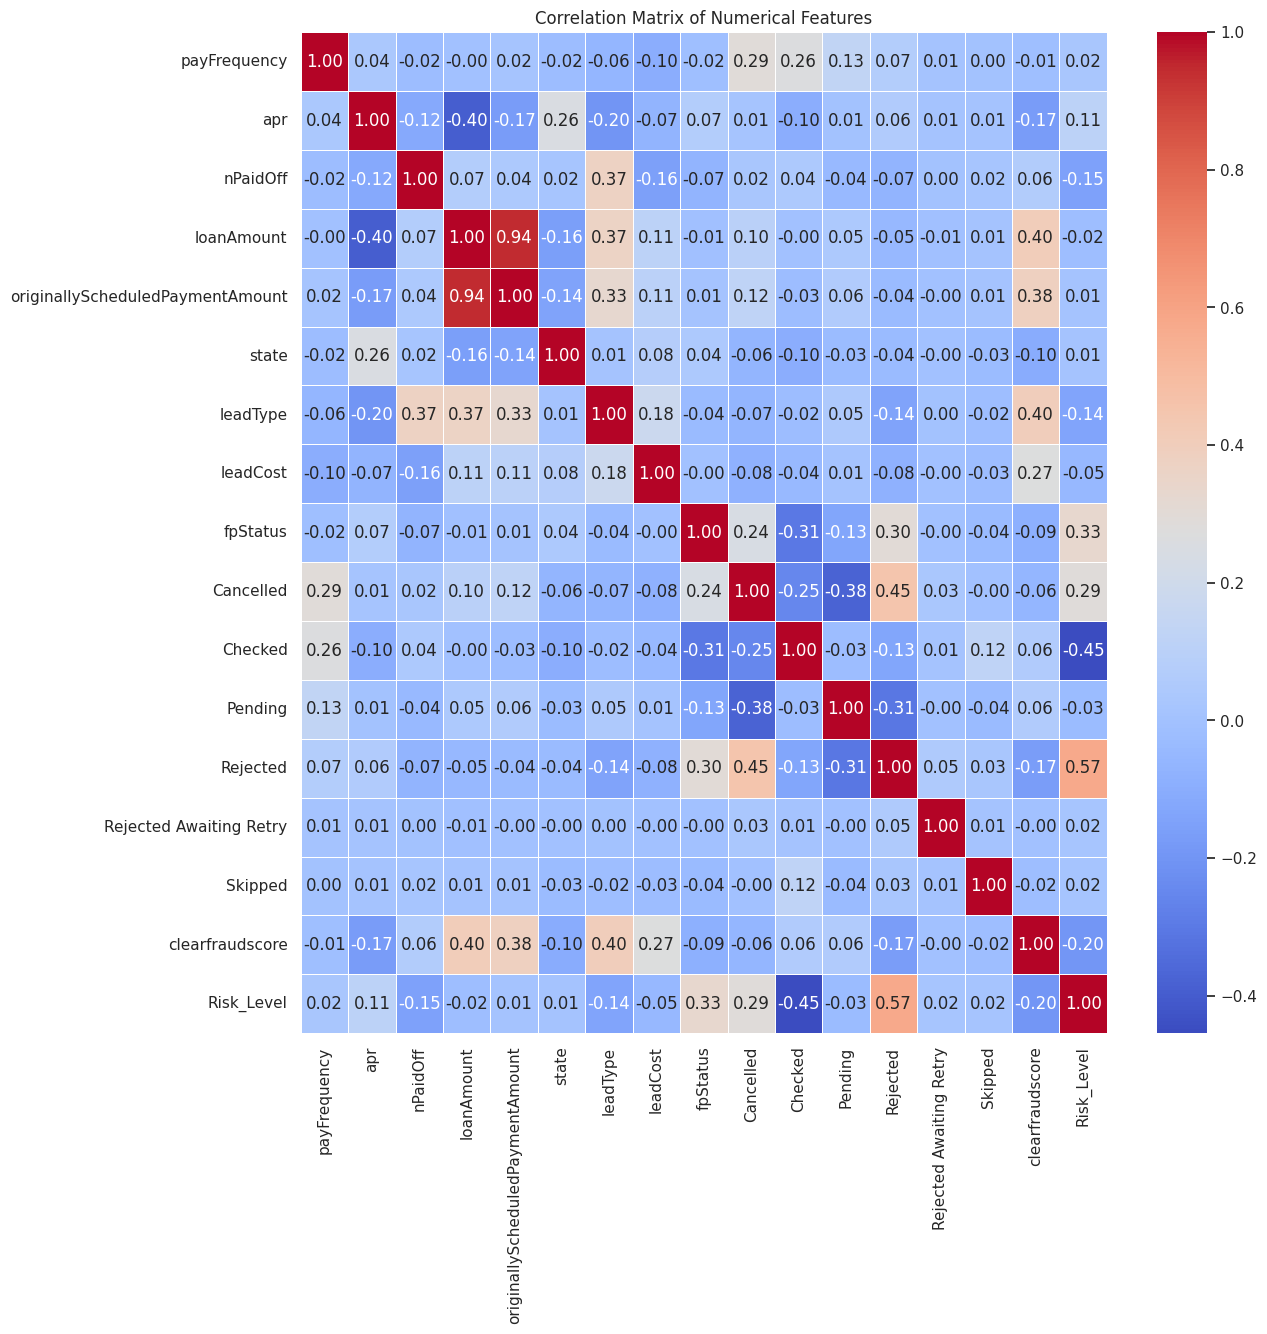

In [ ]:
crr = combine_df.drop(['hasCF', 'Complete', 'Returned'], axis=1)
correlation_matrix = crr.corr()

# Feature Correlation
plt.figure(figsize=(13,13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32081 entries, 0 to 38981
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   payFrequency                      32081 non-null  int64
 1   apr                               32081 non-null  int64
 2   nPaidOff                          32081 non-null  int64
 3   loanAmount                        32081 non-null  int64
 4   originallyScheduledPaymentAmount  32081 non-null  int64
 5   state                             32081 non-null  int64
 6   leadType                          32081 non-null  int64
 7   leadCost                          32081 non-null  int64
 8   fpStatus                          32081 non-null  int64
 9   hasCF                             32081 non-null  int64
 10  Cancelled                         32081 non-null  int64
 11  Checked                           32081 non-null  int64
 12  Complete                          320

In [ ]:
# Model Training
X = combine_df.drop(['Risk_Level'], axis=1)
y = combine_df['Risk_Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# XGboost
param_distributions={'max_depth': randint(1, 11),
                    'subsample': uniform(0.25, 0.75),
                    'colsample_bytree': uniform(0.25, 0.75),
                    "learning_rate": [0.05, 0.1,0.16]

                    }
xgModel = XGBClassifier()
xgModel.fit(X_train, y_train)
rs = RandomizedSearchCV(xgModel,
                        param_distributions,
                        cv=10,
                        n_iter=10,
                        scoring="accuracy",
                        n_jobs=1,
                        verbose=False,
                        random_state=123)

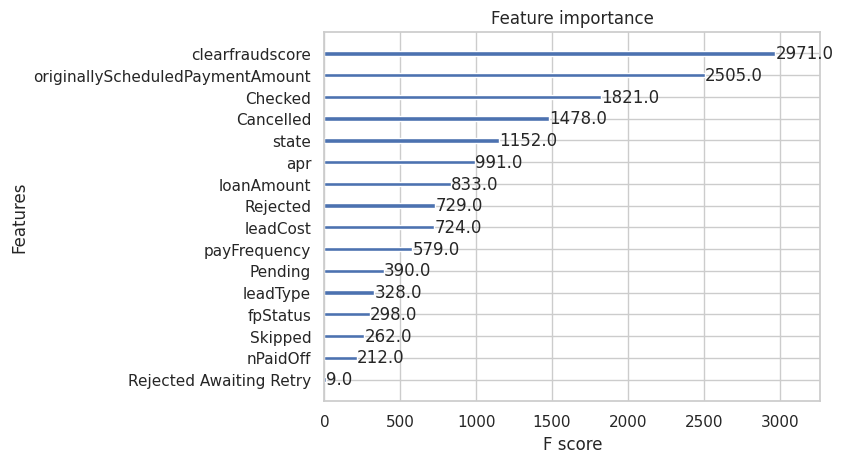

In [ ]:
rs.fit(X_train, y_train)
y_pred_class = rs.predict(X_test)
plot_importance(xgModel)
plt.show()

In [ ]:
methodDict = {}
def evalClassModel(model, y_true, y_pred, verbose=False):
    acc = accuracy_score(y_true, y_pred) * 100
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    if verbose:
        print(f"Model: {model.__class__.__name__}")
        print(f"Accuracy: {acc}%")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)
    return acc

accuracy = evalClassModel(xgModel, y_test, y_pred_class, True)
methodDict['XGBClassifier.'] = accuracy


Model: XGBClassifier
Accuracy: 87.03376623376623%
Confusion Matrix:
[[2406  146  204    0]
 [  68 2186  218    0]
 [  96  420 3785    0]
 [  15    6   75    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2756
           1       0.79      0.88      0.84      2472
           2       0.88      0.88      0.88      4301
           3       0.00      0.00      0.00        96

    accuracy                           0.87      9625
   macro avg       0.65      0.66      0.65      9625
weighted avg       0.87      0.87      0.87      9625



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
y_pred_proba = xgModel.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"The AUC score of the model is: {auc:.3f}")

The AUC score of the model is: 0.912


In [ ]:
pip install catboost

In [ ]:
pip install bayesian-optimization

In [ ]:
from catboost import CatBoostClassifier
from bayes_opt import BayesianOptimization
def catboost_cv(iterations, learning_rate, depth, subsample, rsm):
    params = {
        'loss_function': 'MultiClass',
        'eval_metric': 'TotalF1',
        'iterations': int(iterations),
        'learning_rate': learning_rate,
        'depth': int(depth),
        'subsample': subsample,
        'rsm': rsm,
        'random_seed': 123,
        'l2_leaf_reg': 5,
        'bootstrap_type': 'Bernoulli',
        'sampling_frequency': 'PerTree',
        'use_best_model': True,
        'grow_policy': 'SymmetricTree',
        'min_data_in_leaf': 500,
        'logging_level': 'Silent',
        'early_stopping_rounds': 20
    }

    model = CatBoostClassifier(**params, cat_features=['payFrequency', 'state', 'leadType', 'fpStatus'])
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    test_pred = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, test_pred, multi_class='ovo', average='macro')

    return test_auc

In [ ]:
param_bounds = {
    'iterations': (20, 100),
    'learning_rate': (0.01, 0.2),
    'depth': (4, 10),
    'subsample': (0.6, 1.0),
    'rsm': (0.6, 1.0)
}

cat_bayes = BayesianOptimization(catboost_cv,param_bounds,)

cat_bayes.maximize(init_points=2,n_iter=10)

print(cat_bayes.max)

|   iter    |  target   |   depth   | iterat... | learni... |    rsm    | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8731    | 9.282     | 50.15     | 0.04537   | 0.6838    | 0.9159    |
| 2         | 0.8922    | 6.812     | 49.55     | 0.1306    | 0.6949    | 0.744     |
| 3         | 0.8837    | 9.081     | 64.13     | 0.07779   | 0.7       | 0.763     |
| 4         | 0.8877    | 4.244     | 39.95     | 0.1932    | 0.7103    | 0.8942    |
| 5         | 0.8976    | 7.829     | 88.73     | 0.09687   | 0.8278    | 0.6537    |
| 6         | 0.8916    | 4.278     | 42.43     | 0.1877    | 0.6897    | 0.9301    |
| 7         | 0.8734    | 8.144     | 26.08     | 0.06206   | 0.9698    | 0.8522    |
| 8         | 0.8935    | 5.923     | 90.52     | 0.07014   | 0.7731    | 0.6747    |
| 9         | 0.8966    | 4.829     | 91.57     | 0.1058    | 0.9795    | 0.6299    |
| 10        | 0.9004    | 8.697     | 90.32     | 0.2 

In [ ]:
best_params = cat_bayes.max['params']
print(best_params)

{'depth': 8.697074070902191, 'iterations': 90.32086179205955, 'learning_rate': 0.2, 'rsm': 1.0, 'subsample': 0.6}
